# PPG Feature Extraction and SpO2 Estimation

### Data Dictionary

* **`ecg`**: 3-lead ECG captured at 500Hz
* **`peaks`**: CSV ONLY, annotated in WFDB. The annotated ECG R peak (1 = peak, 0 = no peak)
* **`pleth_1`**: MAX30101 red wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_2`**: MAX30101 infrared wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_3`**: MAX30101 green wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_4`**: MAX30101 red wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_5`**: MAX30101 infrared wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_6`**: MAX30101 green wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`lc_1`**: TAL221 load cell proximal phalanx (first segment) PPG sensor attachment pressure (arbitrary units, 80Hz)
* **`lc_2`**: TAL221 load cell (base segment) PPG sensor attachment pressure (arbitrary units, 80Hz)
* **`temp_1`**: distal phalanx (first segment) PPG sensor temperature (°C, 10Hz)
* **`temp_2`**: proximal phalanx (base segment) PPG sensor temperature in (°C, 10Hz)
* **`temp_3`**: InvenSenseMPU-9250 IMU temperature (°C, 500Hz)
* **`a_x`**: InvenSenseMPU-9250 IMU acceleration in x-direction (g, 500Hz)
* **`a_y`**: InvenSenseMPU-9250 IMU acceleration in y-direction (g, 500Hz)
* **`a_z`**: InvenSenseMPU-9250 IMU acceleration in z-direction (g, 500Hz)
* **`g_x`**: InvenSenseMPU-9250 IMU angular velocity around x-axis (°/s, 500Hz)
* **`g_y`**: InvenSenseMPU-9250 IMU angular velocity around y-axis (°/s, 500Hz)
* **`g_z`**: InvenSenseMPU-9250 IMU angular velocity around z-axis (°/s, 500Hz)
* Each CSV record includes a **`time`** column that was date shifted to de-indentify participants.

## 1. Data Loading & EDA

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from scipy.ndimage import gaussian_filter1d
import sys

In [2]:
# Python file imports
sys.path.append("../src")
from load_data import load_signal_csv, load_metadata_csv, plot_ppg, check_missing_values

In [3]:
# Loading and exploring the data

df = load_signal_csv("../data/csv/s15_sit.csv")
df.head()

,time,ecg,peaks,pleth_1,pleth_2,pleth_3,pleth_4,pleth_5,pleth_6,lc_1,lc_2,temp_1,temp_2,temp_3,a_x,a_y,a_z,g_x,g_y,g_z
0,2021-01-01 14:59:08.681706,33756,0,82753,84257,7379,92409,103346,6736,7058792,6681695,30.0,32.88,31.692783,3.960810,6.387457,-6.377281,0.005177,0.006862,0.003501
1,2021-01-01 14:59:08.683706,33801,0,82735,84262,7382,92412,103312,6740,7058792,6681695,30.0,32.88,31.686794,3.948838,6.391048,-6.372492,0.005310,0.006063,0.003501
2,2021-01-01 14:59:08.685706,33915,0,82752,84258,7392,92406,103314,6736,7058769,6682423,30.0,32.88,31.683800,3.946444,6.389253,-6.371894,0.004378,0.004065,0.003368
3,2021-01-01 14:59:08.687706,34040,0,82754,84256,7380,92406,103314,6736,7058769,6682423,30.0,32.88,31.683800,3.946444,6.389253,-6.371894,0.004378,0.004065,0.003368
4,2021-01-01 14:59:08.689706,34035,0,82754,84256,7380,92422,103310,6737,7058769,6682423,30.0,32.88,31.692783,3.932078,6.395238,-6.377281,0.002780,0.002201,0.003501


In [6]:
df["peaks"].value_counts()

peaks
0    241503
1       685
Name: count, dtype: int64

In [5]:
subject_df = load_metadata_csv("../data/csv/subjects_info.csv")
subject_df.head()

,record,activity,gender,height,weight,age,bp_sys_start,bp_sys_end,bp_dia_start,bp_dia_end,hr_1_start,hr_1_end,hr_2_start,hr_2_end,spo2_start,spo2_end
0,s1_walk,walk,female,160,50,25,94,90,67,63,89,73,78,77,96,97
1,s1_run,run,female,160,50,25,92,94,72,76,65,78,69,71,99,98
2,s1_sit,sit,female,160,50,25,87,87,59,57,74,74,69,70,98,98
3,s2_walk,walk,male,175,70,20,125,122,84,74,112,114,107,110,96,96
4,s2_run,run,male,175,70,20,122,136,74,83,114,118,110,119,96,96


In [6]:
# missing = check_missing_values("../data/csv")
# missing

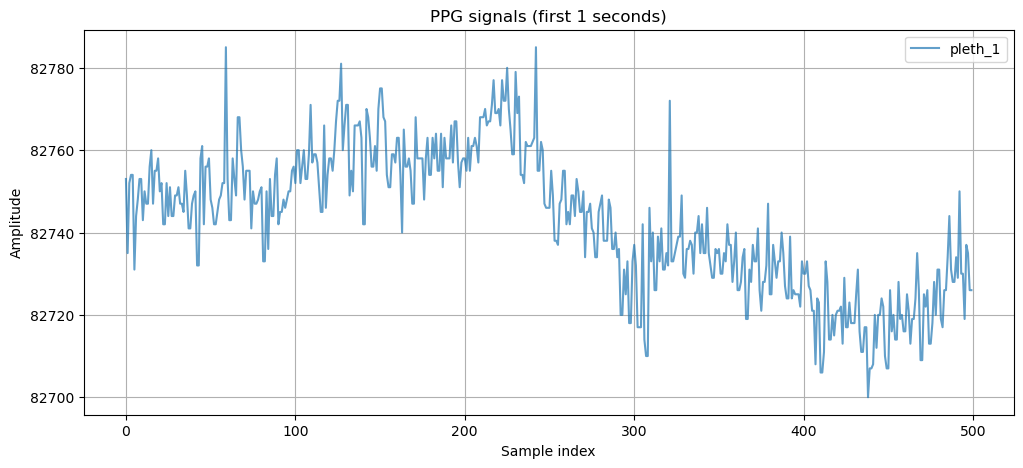

In [4]:
# Visualizing pleth_1 and pleth_2
plot_ppg(df, channels=['pleth_1'], seconds=1, fs=500)

## 2. Data Preprocessing

In [4]:
from preprocess import preprocess_ppg, plot_ppg_filtered

preprocessed_df = preprocess_ppg(df, channels=['pleth_1', 'pleth_2'], fs=500)
preprocessed_df.head()

,time,ecg,peaks,pleth_1,pleth_2,pleth_3,pleth_4,pleth_5,pleth_6,lc_1,...,temp_2,temp_3,a_x,a_y,a_z,g_x,g_y,g_z,pleth_1_filtered,pleth_2_filtered
0,2021-01-01 14:59:08.681706,33756,0,82753,84257,7379,92409,103346,6736,7058792,...,32.88,31.692783,3.960810,6.387457,-6.377281,0.005177,0.006862,0.003501,-3.258834,-24.362287
1,2021-01-01 14:59:08.683706,33801,0,82735,84262,7382,92412,103312,6740,7058792,...,32.88,31.686794,3.948838,6.391048,-6.372492,0.005310,0.006063,0.003501,-3.382607,-24.837016
2,2021-01-01 14:59:08.685706,33915,0,82752,84258,7392,92406,103314,6736,7058769,...,32.88,31.683800,3.946444,6.389253,-6.371894,0.004378,0.004065,0.003368,-3.507571,-25.293050
3,2021-01-01 14:59:08.687706,34040,0,82754,84256,7380,92406,103314,6736,7058769,...,32.88,31.683800,3.946444,6.389253,-6.371894,0.004378,0.004065,0.003368,-3.633493,-25.729769
4,2021-01-01 14:59:08.689706,34035,0,82754,84256,7380,92422,103310,6737,7058769,...,32.88,31.692783,3.932078,6.395238,-6.377281,0.002780,0.002201,0.003501,-3.760141,-26.146597


In [6]:
preprocessed_df["pleth_1"].mean(), preprocessed_df["pleth_1"].median()

(82092.84821295853, 82057.0)

In [7]:
preprocessed_df["pleth_1_filtered"].mean(), preprocessed_df["pleth_1_filtered"].median()

(3.484749591123038e-05, -1.152639034285049)

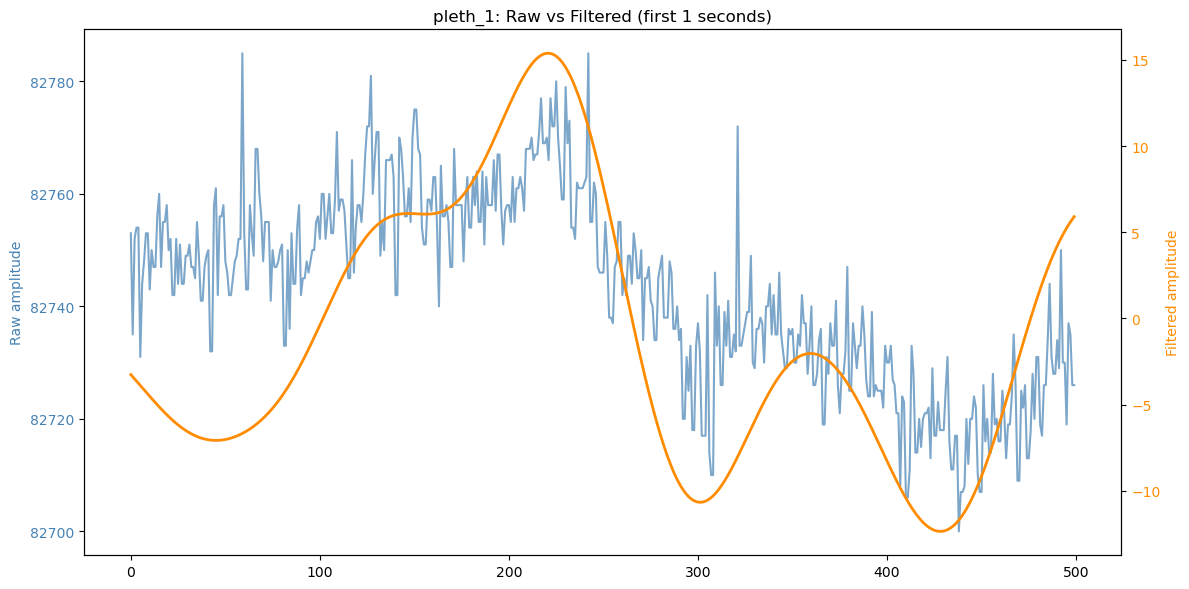

In [8]:
plot_ppg_filtered(preprocessed_df, channel='pleth_1', seconds=1)

## 3. Identifying Systolic Peaks, Dicrotic Notch, and Diastolic Peaks

### Physiological context: PPG waveform

The **photoplethysmography (PPG) waveform** reflects blood volume changes in the microvascular bed of tissue (often finger/ear sensors).
A single cardiac cycle produces a characteristic shape:

* **Systolic peak (main peak):**
  The tallest peak in the waveform. It corresponds to the maximum blood volume during **systole** (when the heart contracts and pumps blood into the arteries).

* **Dicrotic notch:**
  A small downward deflection after the systolic peak. It’s associated with **aortic valve closure** and the beginning of diastole.

* **Diastolic peak (secondary peak):**
  A smaller “second bump” after the dicrotic notch, representing reflective waves in the arterial system during **diastole**.

So each cycle looks like:
Rise → **Systolic peak** → Dip (**Dicrotic notch**) → Small **Diastolic peak**.

* **Heart rate:**
  Heart rate is derived from systolic-to-systolic spacing.
  
  Compute distance between consecutive systolic peaks -> divide by fs and convert to seconds (RR interval = time between beats)
  
  HR = 60 / mean(RR interval) → beats per minute.


In [5]:
from feature_extraction import build_feature_dataframe

df_features = build_feature_dataframe(preprocessed_df["pleth_2_filtered"], fs=500)
df_features.tail()

,sys_idx,notch_idx,dia_idx,systolic_amp,notch_amp,diastolic_amp,systolic_time,notch_time,diastolic_time,rise_time,pulse_width,heart_rate
678,240484,240572,NaN,59.917059,-57.853878,NaN,480.968,481.144,NaN,0.176,NaN,108.695652
679,240760,240851,NaN,65.033393,-43.790256,NaN,481.520,481.702,NaN,0.182,NaN,109.890110
680,241033,241125,NaN,60.911159,-57.756777,NaN,482.066,482.250,NaN,0.184,NaN,104.895105
681,241319,241415,NaN,66.433680,-45.729216,NaN,482.638,482.830,NaN,0.192,NaN,105.263158
682,241604,241699,NaN,54.998346,-62.365768,NaN,483.208,483.398,NaN,0.190,NaN,103.806228


In [6]:
df_features["heart_rate"].mean()

86.12462330247055

In [16]:
df_features.isna().sum()

sys_idx             0
notch_idx           0
dia_idx           361
systolic_amp        0
notch_amp           0
diastolic_amp     361
systolic_time       0
notch_time          0
diastolic_time    361
rise_time           0
pulse_width       361
heart_rate          0
dtype: int64

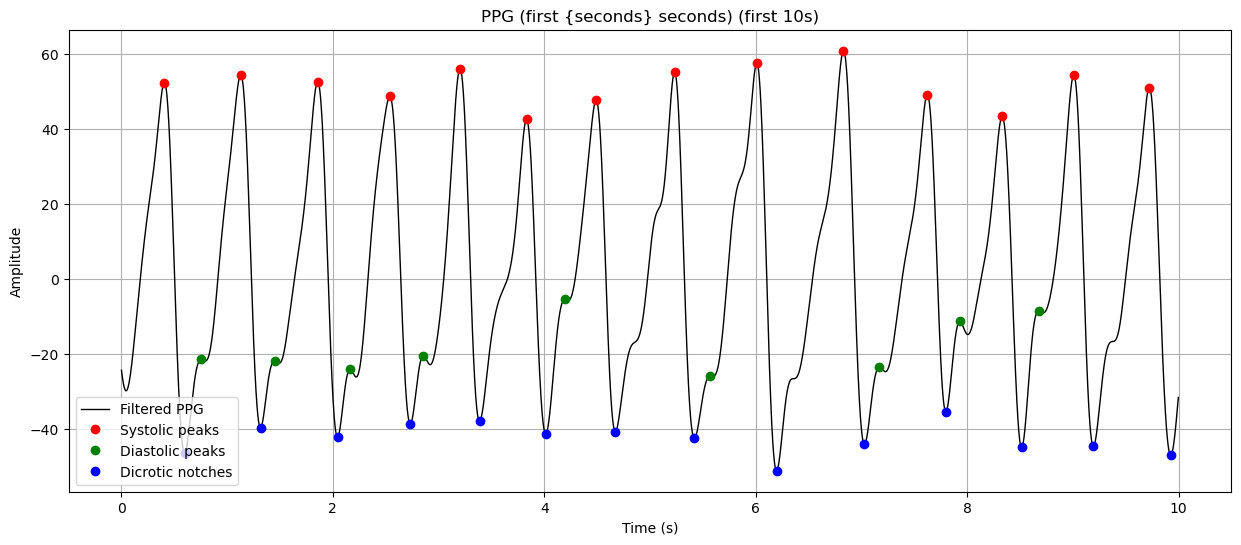

In [8]:
from feature_extraction import plot_ppg_with_features

plot_ppg_with_features(
    ppg=preprocessed_df["pleth_2_filtered"], 
    fs=500,
    systolic_peaks=df_features["sys_idx"], 
    diastolic_peaks=df_features["dia_idx"], 
    notches=df_features["notch_idx"],
    seconds=10
)

## 4. SpO2 Estimation

* Typically, IR (pleth\_2) has a **stronger signal-to-noise ratio** in finger PPG → so it’s common to use **pleth\_2\_filtered** for peak detection.
* Then apply those systolic indices to **both pleth\_1\_filtered (Red)** and **pleth\_2\_filtered (IR)** when computing AC/DC ratios.


In [9]:
systolic_peaks = df_features["sys_idx"].values

# create beat intervals (start, end)
beat_intervals = [(systolic_peaks[i], systolic_peaks[i+1]) for i in range(len(systolic_peaks)-1)]

In [10]:
beat_intervals[:5]

[(203, 564), (564, 928), (928, 1269), (1269, 1601), (1601, 1916)]

In [11]:
from spo2_estimation import extract_spo2_features

spo2_estimated_df = extract_spo2_features(red_signal=preprocessed_df["pleth_1_filtered"],
                                          ir_signal=preprocessed_df["pleth_2_filtered"],
                                          beats=beat_intervals,
                                          A=110.0,
                                          B=25.0)

spo2_estimated_df.head()

,beat_idx,R_ratio,SpO2_est
0,0,1.326526,76.836858
1,1,0.010453,109.738668
2,2,0.052369,108.690768
3,3,1.486909,72.827282
4,4,0.167275,105.818118


In [12]:
# Keeping only those spo2 values that range between 70 and 100
usable_df = spo2_estimated_df.copy()
usable_df = usable_df[(usable_df["SpO2_est"] >= 70) & (usable_df["SpO2_est"] <= 100)]
usable_df = usable_df[(usable_df["R_ratio"] > 0.3) & (usable_df["R_ratio"] < 1.2)]
usable_df = usable_df.reset_index(drop=True)
usable_df.head()

,beat_idx,R_ratio,SpO2_est
0,9,1.067852,83.303712
1,20,0.837746,89.056348
2,32,0.407798,99.805053
3,42,1.139623,81.509437
4,44,0.751444,91.213912


In [13]:
usable_df["SpO2_est"].mean()

93.29555590598471

## Running Pipeline

In [3]:
DATA_DIR = "../data/csv"
OUTPUT_DIR = "../manualoutputs"

In [4]:
from manual_pipeline import run_pipeline
run_pipeline(data_dir=DATA_DIR, output_dir=OUTPUT_DIR, A=110, B=25)

Processing ../data/csv\s10_run.csv...
Saved ../manualoutputs\s10_run_features.csv
Processing ../data/csv\s10_sit.csv...
Saved ../manualoutputs\s10_sit_features.csv
Processing ../data/csv\s10_walk.csv...
Saved ../manualoutputs\s10_walk_features.csv
Processing ../data/csv\s11_run.csv...
Saved ../manualoutputs\s11_run_features.csv
Processing ../data/csv\s11_sit.csv...
Saved ../manualoutputs\s11_sit_features.csv
Processing ../data/csv\s11_walk.csv...
Saved ../manualoutputs\s11_walk_features.csv
Processing ../data/csv\s12_run.csv...
Saved ../manualoutputs\s12_run_features.csv
Processing ../data/csv\s12_sit.csv...
Saved ../manualoutputs\s12_sit_features.csv
Processing ../data/csv\s12_walk.csv...
Saved ../manualoutputs\s12_walk_features.csv
Processing ../data/csv\s13_run.csv...
Saved ../manualoutputs\s13_run_features.csv
Processing ../data/csv\s13_sit.csv...
Saved ../manualoutputs\s13_sit_features.csv
Processing ../data/csv\s13_walk.csv...
Saved ../manualoutputs\s13_walk_features.csv
Processi